In [1]:
import pandas as pd
import healpy as hp
import numpy as np
import ligo.skymap
import argparse
import matplotlib.pyplot as plt

from matplotlib import rcParams
from pathlib import Path
from ligo.skymap import io, kde, postprocess
from ligo.skymap.plot.marker import reticle

import h5py


In [2]:
f1 = h5py.File("/fred/oz016/Chayan/SNR_time_series_sample_files/GW170817/GW170817_test_3_det_all_SNR_ResNet-34.hdf", "r")

probs = f1["Probabilities"][()]
ra_preds = f1["RA_samples"][()]
dec_preds = f1["Dec_samples"][()]
ra_test = f1["RA_test"][()]
dec_test = f1["Dec_test"][()]

f1.close()


In [3]:
pts = np.stack([ra_preds, dec_preds], axis=2)


In [4]:
sky_posterior = []

for i in range(1):
    sky_posterior.append(kde.Clustered2DSkyKDE(pts[i], trials=3, jobs=5))


In [5]:
hpmap = []

for i in range(1):
    hpmap.append(sky_posterior[i].as_healpix())


adaptive refinement round 1 of 7 ...
adaptive refinement round 2 of 7 ...
adaptive refinement round 3 of 7 ...
adaptive refinement round 4 of 7 ...
adaptive refinement round 5 of 7 ...
adaptive refinement round 6 of 7 ...
adaptive refinement round 7 of 7 ...


In [6]:
for i in range(1):
    io.write_sky_map('skymaps/Test_GW170817_train_5_new_'+str(i)+'_1.fits', hpmap[i], nest=True)


In [7]:
skymap = []

for i in range(1):
    s, metadata = io.fits.read_sky_map('skymaps/Test_GW170817_train_5_new_'+str(i)+'_1.fits', nest=None)
    skymap.append(s)
    

In [8]:
preds, metadata = io.fits.read_sky_map('/fred/oz016/Chayan/SNR_time_series_sample_files/GW170817_bayestar.fits', nest=None)


In [9]:
skymap, metadata = io.fits.read_sky_map('skymaps/Test_GW170817_train_5_new_0_1.fits', nest=None)
nside = hp.npix2nside(len(skymap))


Text(1, 1, '50% area: 14 deg²\n90% area: 48 deg²')

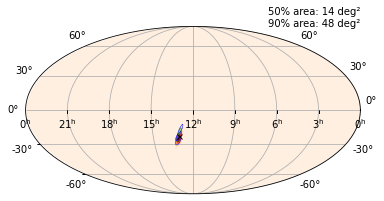

In [11]:
from astropy.coordinates import SkyCoord
# Convert to probability per square degree
deg2perpix = hp.nside2pixarea(nside, degrees=True)
probperdeg2 = skymap / deg2perpix

ax = plt.axes(projection="astro hours mollweide")
ax.grid()

event_ra = ra_test[0]
event_de = dec_test[0]

vmax = probperdeg2.max()
vmin = probperdeg2.min()
ax.imshow_hpx((probperdeg2, 'ICRS'), nested=True, vmin=vmin, vmax=vmax, cmap='cylon')
confidence_levels = 100 * postprocess.find_greedy_credible_levels(skymap)
confidence_levels_pe = 100 * postprocess.find_greedy_credible_levels(preds)

contours = ax.contour_hpx((confidence_levels, 'ICRS'), nested=metadata['nest'],linewidths=0.5,levels=[50,90],colors=['green','blue'])
contours_pe = ax.contour_hpx((confidence_levels_pe, 'ICRS'), nested=metadata['nest'],linewidths=0.5,levels=[50,90],colors=['green','blue'])
#cs = postprocess.contour(m, [50,90], degrees=True)
ax.plot_coord(SkyCoord(event_ra, event_de, unit='rad'), 'x',markeredgecolor='black', markersize=5)

text = []
pp = np.round([50,90]).astype(int)
ii = np.round(np.searchsorted(np.sort(confidence_levels),[50,90]) * deg2perpix).astype(int)
#ii_90 = np.sum(confidence_levels <= 90) * hp.nside2pixarea(nside, degrees=True)
#ii_50 = np.sum(confidence_levels <= 50) * hp.nside2pixarea(nside, degrees=True)
#ii = np.round([ii_50,ii_90]).astype(int)
for i, p in zip(ii, pp):
            # FIXME: use Unicode symbol instead of TeX '$^2$'
            # because of broken fonts on Scientific Linux 7.
            text.append(u'{:d}% area: {:d} deg²'.format(p, i, grouping=True))
ax.text(1, 1, '\n'.join(text), transform=ax.transAxes, ha='right')
#ax.figure.savefig('Localization_after_autoencoder/GWOSC_files_from_autoencoder_final/Localization_plots/CNN_MDN_GW170823_test_NSIDE64.png',dpi=150)
#ax.figure.savefig('Preds_test_0.png',dpi=400)


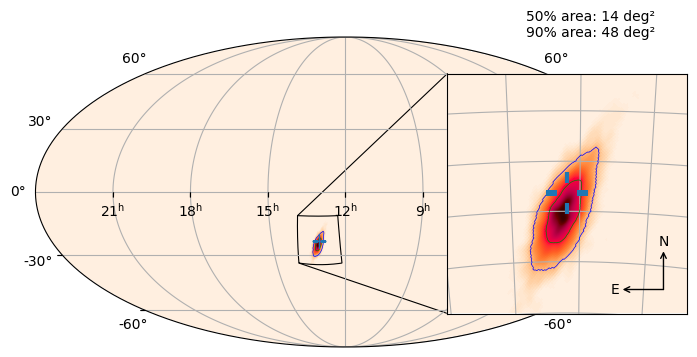

In [19]:
#ra, dec = (ra_test, dec_test)  # fits well
#ra, dec = (6.25, -np.pi/3)  # close to boundary
ra, dec = (3.42695399, -0.40526545)
center = SkyCoord(unit='rad', ra=ra, dec=dec)

# display
fig = plt.figure(figsize=(8, 6), dpi=100)
ax = fig.add_subplot(
    111,
    projection='astro hours mollweide',
#     title=f"{Time(obstime, format='iso', scale='utc')}",
)
ax.title.set_size(11)

ax_inset = plt.axes(
    [0.59, 0.3, 0.4, 0.4],
    projection='astro zoom',
    center='13.09h -23.22d',
    radius='12 deg'
)

for key in ['ra', 'dec']:
    ax_inset.coords[key].set_ticklabel_visible(False)
    ax_inset.coords[key].set_ticks_visible(False)


# Hanford and Livingston frame at time of event
# obstime = Time(Merger('GW150914').time, format='gps')
# frame = DetectorFrame(
#     site_1=EarthLocation.of_site('H1'),
#     site_2=EarthLocation.of_site('L1'),
#     obstime=obstime
# )
# ax.get_coords_overlay(frame).grid()
# ax_inset.get_coords_overlay(frame).grid()

ax.grid()
ax_inset.grid()

ax.mark_inset_axes(ax_inset)
ax.connect_inset_axes(ax_inset, 'upper left')
ax.connect_inset_axes(ax_inset, 'lower left')
#ax_inset.scalebar((0.1, 0.1), 5 deg).label()
ax_inset.compass(0.9, 0.1, 0.2)

ax.imshow_hpx(
    skymap,
    cmap='cylon',
    vmin=skymap.min(),
    vmax=skymap.max(),
    nested=True
)
ax.plot(
    center.ra.deg, center.dec.deg,
    transform=ax.get_transform('world'),
     marker=ligo.skymap.plot.reticle(inner=0),
    markersize=10,
    markeredgewidth=1
)

ax.contour_hpx((confidence_levels, 'ICRS'), nested=metadata['nest'],linewidths=0.5,levels=[50,90],colors=['green','blue'])
ax_inset.contour_hpx((confidence_levels, 'ICRS'), nested=metadata['nest'],linewidths=0.5,levels=[50,90],colors=['green','blue'])

#ax.contour_hpx((confidence_levels_pe, 'ICRS'), nested=metadata['nest'],linewidths=0.5,levels=[50,90],colors=['black','brown'])
#ax_inset.contour_hpx((confidence_levels_pe, 'ICRS'), nested=metadata['nest'],linewidths=0.5,levels=[50,90],colors=['black','brown'])

ax_inset.imshow_hpx(
    skymap,
    cmap='cylon',
    vmin=skymap.min(),
    vmax=skymap.max(),
    nested=True
)
ax_inset.plot(
    center.ra.deg, center.dec.deg,
    transform=ax_inset.get_transform('world'),
     marker=ligo.skymap.plot.reticle(),
    markersize=30,
    markeredgewidth=3,
)

text = []
pp = np.round([50,90]).astype(int)
ii = np.round(np.searchsorted(np.sort(confidence_levels),[50,90]) * deg2perpix).astype(int)

for i, p in zip(ii, pp):
#            # FIXME: use Unicode symbol instead of TeX '$^2$'
#            # because of broken fonts on Scientific Linux 7.
            text.append(u'{:d}% area: {:d} deg²'.format(p, i, grouping=True))
ax.text(1, 1, '\n'.join(text), transform=ax.transAxes, ha='right')

#plt.show()

plt.savefig('GW170817_localization_Gaussian.png', bbox_inches='tight', facecolor='w', transparent=False, dpi=200)
